# Cloud Assess

This notebook demonstrates Cloud Assess.

## VM workload simulation

We simulate a workload of virtual machines (VM) as follows.
- The period is 1 month, i.e. 30 days
- The granularity of 1 hour, i.e. 24*30 = 720 measure points per VM
- 10 clients, each client creates 1 VM
- Each VM starts and ends at a random time
- Each VM is specified by a random RAM, vCPU and storage usage

In [94]:
from dataclasses import dataclass, asdict
from random import randint

import pandas as pd
from requests import post
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
period = 30 # days
delta_t = 1 # hour
t_max = period * 24 - 1 # clock ends at last tick

@dataclass
class VM:
    uid : str
    start: int
    end: int
    ram: int # GB
    vcpu: int # dimensionless
    storage: int # GB

def gen_vm(uid: str) -> VM:
    start = randint(0, t_max)
    end = start + randint(0, t_max - start)
    ram = randint(2, 64)
    vcpu = randint(1, 8)
    storage = randint(100, 2000)
    return VM(uid, start, end, ram, vcpu, storage)

def gen_usage(n_clients) -> list[VM]:
    return [gen_vm(f"client_{i}") for i in range(n_clients)]


In [52]:
@dataclass
class TimeSlice:
    t: int
    active_vms: list[VM]

    def total_ram(self) -> int:
        return sum([vm.ram for vm in self.active_vms])

    def total_vcpu(self) -> int:
        return sum([vm.vcpu for vm in self.active_vms])

    def total_storage(self) -> int:
        return sum([vm.storage for vm in self.active_vms])

@dataclass
class Workload:
    slices: list[TimeSlice]

    def __init__(self, vms: list[VM]):
        self.slices = []
        for t in range(0, t_max):
            active_vms = [vm for vm in vms if (vm.start <= t) and (vm.end >= t)]
            self.slices.append(TimeSlice(t, active_vms))

In [53]:
n_clients = 10
workload = Workload(gen_usage(n_clients))

## Invoking Cloud Assess

We push the workload to Cloud Assess API and collect the impacts for every client.

### Mappers

Some utility functions to prepare the API requests.

In [102]:
pool_id = "worker"

def vm_dto(vm: VM):
    return {
        "id": vm.uid,
        "pool_id": pool_id,
        "quantity": {
            "amount": 1.0,
            "unit": "u"
        },
        "ram": {
            "amount": vm.ram,
            "unit": "GB"
        },
        "vcpu": {
            "amount": vm.vcpu,
            "unit": "vCPU",
        },
        "storage": {
            "amount": vm.storage,
            "unit": "GB",
        },
    }

def request_dto(t_slice: TimeSlice):
    return {
        "period": {
            "amount": delta_t,
            "unit": "hour",
        },
        "total_ram": {
            "amount": t_slice.total_ram(),
            "unit": "GB",
        },
        "total_vcpu": {
            "amount": t_slice.total_vcpu(),
            "unit": "vCPU",
        },
        "total_storage": {
            "amount": t_slice.total_storage(),
            "unit": "GB",
        },
        "virtual_machines": [vm_dto(vm) for vm in t_slice.active_vms]
    }

### Collect impacts


In [103]:
@dataclass
class Impact:
    unit: str
    total: float
    manufacturing: float
    transport: float
    use: float
    end_of_life: float

@dataclass
class Measure:
    uid: str # client id
    t: int # time of measurement
    gwp: Impact
    wu: Impact

def collect_measures(workload: Workload) -> list[Measure]:
    measures = []
    for t, t_slice in enumerate(workload.slices):
        dto = request_dto(t_slice)
        dto_response = post("http://localhost:8080/virtual_machines/assess", json=dto).json()
        for vm_response in dto_response["virtual_machines"]:
            uid = vm_response["request"]["id"]
            gwp = Impact(
                vm_response["impacts"]["GWP"]["total"]["unit"],
                vm_response["impacts"]["GWP"]["total"]["amount"],
                vm_response["impacts"]["GWP"]["per_lc_step"]["manufacturing"]["amount"],
                vm_response["impacts"]["GWP"]["per_lc_step"]["transport"]["amount"],
                vm_response["impacts"]["GWP"]["per_lc_step"]["use"]["amount"],
                vm_response["impacts"]["GWP"]["per_lc_step"]["end_of_life"]["amount"],
            )
            wu = Impact(
                vm_response["impacts"]["WU"]["total"]["unit"],
                vm_response["impacts"]["WU"]["total"]["amount"],
                vm_response["impacts"]["WU"]["per_lc_step"]["manufacturing"]["amount"],
                vm_response["impacts"]["WU"]["per_lc_step"]["transport"]["amount"],
                vm_response["impacts"]["WU"]["per_lc_step"]["use"]["amount"],
                vm_response["impacts"]["WU"]["per_lc_step"]["end_of_life"]["amount"],
            )
            measures.append(Measure(uid, t, gwp, wu))
    return measures


In [104]:
measures = collect_measures(workload)

In [105]:
import pickle
with open("ignored/measures.pickle", "wb") as f:
    pickle.dump(measures, f)

## Visualization


In [111]:
gwp_measures = list(map(lambda m:  {
    "uid": m.uid,
    "time": m.t,
    "total": m.gwp.total,
    "manufacturing": m.gwp.manufacturing,
    "transport": m.gwp.transport,
    "use": m.gwp.use,
    "end_of_life": m.gwp.end_of_life,
}, measures))
gwp_df = pd.DataFrame.from_records(gwp_measures)
gwp_df.head()

,uid,time,total,manufacturing,transport,use,end_of_life
0,client_0,51,27.701328,23.455029,-0.0,4.246298,-0.0
1,client_0,52,27.701328,23.455029,-0.0,4.246298,-0.0
2,client_0,53,27.701328,23.455029,-0.0,4.246298,-0.0
3,client_0,54,27.701328,23.455029,-0.0,4.246298,-0.0
4,client_0,55,27.701328,23.455029,-0.0,4.246298,-0.0


Let's visualize the total impact in time of a given client.

In [113]:
def plot_client(target_client: str):
    gwp_df_target = gwp_df[gwp_df["uid"] == target_client]
    plt.stackplot(gwp_df_target["time"],
                  gwp_df_target["manufacturing"],
                  gwp_df_target["transport"],
                  gwp_df_target["use"],
                  gwp_df_target["end_of_life"],
                  labels=['manufacturing', 'transport', 'use', 'end_of_life']
                  )
    sns.lineplot(x="time", y="total", data=gwp_df_target, drawstyle="steps-post")
    plt.title(f"GWP of {target_client}")
    plt.legend(loc='upper right')


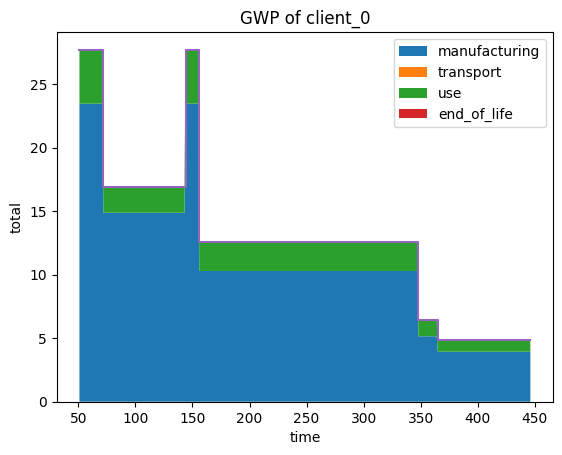

In [114]:
plot_client("client_0")


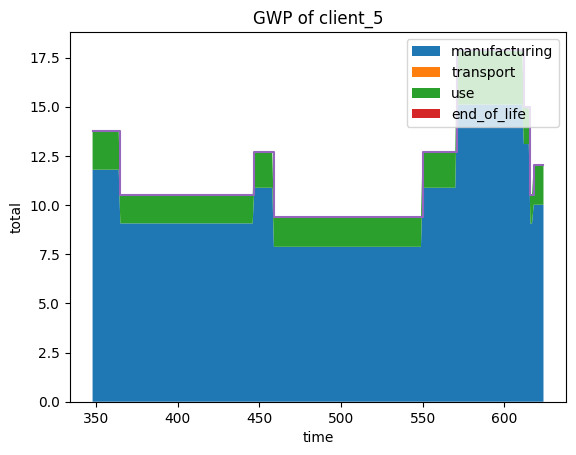

In [115]:
plot_client("client_5")